In [1]:
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Introduction
# In this project, we'll be looking at wind turbines, and creating regression models based off of various features. The most important question I want 
# to answer with this project is: "Can we create a model that can accurately predict the power generated by wind turbines?", I would also like to 
# explore and see how the various features play a role in the predicting power of our models. I think that this will be influential and more developed 
# forms of the models that I intend to create here could actually be useful to companies that deal with wind turbines specifically, such as helping 
# in determining which features to look out for when building wind turbines, as well as companies that deal with other potential sources of
# energy where the information is applicable. 

# Our dataset comes from Kaggle, and can be found here: https://www.kaggle.com/datasets/sudhanvahg/wind-turbine-power-generation-forecasting
# This dataset includes data on the hourly meteorological data along with power output measurements from wind turbines collected between Jan 2013 
# and December 2016. The data is split into two portions, a train set and a test set. We'll only be working with the training set, as the test set
# does not include a column for the "power" feature, which I intend to be our target in our models. The included variables are temperature at 2 meters,
# relative humidity at 2 meters, dew point at 2 meters, wind speed at different altitudes (10 meters, 100 meters), and wind direction for these
# altitudes as well. There are 140160 entries in our training dataset. There are no null values.

In [3]:
# What is Regression?
# Regression is a way to predict unknown values based on values we already know based on the trends and relationships within the data. Linear regression
# fits lines to our existing data, picks the best one, and then uses that line to predict future values that we don't already know. It's like making an
# educated guess!

# How we'll be evaluating our models:
# One of the ways to measure how good of a model we have is the R-squared value of a model. The R-squared value is a ratio of the residual sum of 
# squared divided by the total sum of squares. Here's what the scores mean in layman's terms: R-Squared values closer to 0 mean the values predicted
# by the model are as good as randomly guessing, while values closer to 1 are like we already knew the values prior to predicting them.
# Another score we'll be using to measure how good our model's predictions are is RMSE, or Root Mean Square Error, which tells us how far off our
# predicted values are from the actual values. The closer the RMSE score is to 0, the more accurate our model's predictions are.


In [4]:
wt_train_df_raw = pd.read_csv("train.csv")
wt_train_df_raw.describe()

Unnamed: 0       Location        Temp_2m      RelHum_2m  \
count  140160.000000  140160.000000  140160.000000  140160.000000   
mean    17519.500000       2.500000      45.912162      70.420512   
std     10115.212797       1.118038      21.930554      17.000203   
min         0.000000       1.000000     -31.420400       8.664205   
25%      8759.750000       1.750000      29.579600      57.664205   
50%     17519.500000       2.500000      45.879600      72.664205   
75%     26279.250000       3.250000      64.579600      84.664205   
max     35039.000000       4.000000      94.479600      99.664205   

               DP_2m         WS_10m        WS_100m         WD_10m  \
count  140160.000000  140160.000000  140160.000000  140160.000000   
mean       35.867228       4.352948       6.924278     200.684417   
std        20.979720       2.027149       3.056636     100.079917   
min       -36.627405       0.165389       0.007799       0.051683   
25%        21.172595       2.815389       4.747799     128.051683   
50%        35.672595       4.055389       6.717799     211.051683   
75%        53.872595       5.575389       8.847799     287.051683   
max        78.272595      18.695389      24.597799     359.051683   

             WD_100m         WG_10m          Power  
count  140160.000000  140160.000000  140160.000000  
mean      200.649010       8.027673       0.312437  
std       101.105919       3.626641       0.253774  
min        -0.942685       0.436515      -0.000004  
25%       127.057315       5.236515       0.099696  
50%       211.057315       7.636515       0.246896  
75%       289.057315      10.236515       0.486396  
max       359.057315      28.936515       0.988796

In [5]:
wt_train_df_raw.isna().sum()

Unnamed: 0    0
Time          0
Location      0
Temp_2m       0
RelHum_2m     0
DP_2m         0
WS_10m        0
WS_100m       0
WD_10m        0
WD_100m       0
WG_10m        0
Power         0
dtype: int64

In [6]:
# Preprocessing
# We'll start by dropping the "Unnamed: 0", Location, and "Time" columns. The "Unnamed: 0" column is just an index column, so we won't need that.
# The "Time" column could potentially hold a lot of valuable information if we were to break it down by season, and the time of day. Unfortunately for
# my own sake, I'll be choosing to not explore this option for this project - I don't think that the juice is worth the squeeze or that the difference 
# between times of day and seasons will produce different enough results from looking at everything alltogether. Additionally, we'll
# remove the outliers from our data. This can be accomplished by removing entries that are over 3 standard deviations from the mean (average) of our
# data set. The reason we're choosing that number is because approximately 99.7% of our data should lie within 3 standard deviations of the mean.
# Removing these entries will help prevent our data from skewing the results of our models, and since our dataset has over 100,000 entries, we 
# should still have plenty of information to work with.

In [99]:
wt_train_df = wt_train_df_raw.drop('Unnamed: 0', axis=1)
wt_train_df = wt_train_df.drop('Time', axis = 1)
wt_train_df.describe()

Location        Temp_2m      RelHum_2m          DP_2m  \
count  140160.000000  140160.000000  140160.000000  140160.000000   
mean        2.500000      45.912162      70.420512      35.867228   
std         1.118038      21.930554      17.000203      20.979720   
min         1.000000     -31.420400       8.664205     -36.627405   
25%         1.750000      29.579600      57.664205      21.172595   
50%         2.500000      45.879600      72.664205      35.672595   
75%         3.250000      64.579600      84.664205      53.872595   
max         4.000000      94.479600      99.664205      78.272595   

              WS_10m        WS_100m         WD_10m        WD_100m  \
count  140160.000000  140160.000000  140160.000000  140160.000000   
mean        4.352948       6.924278     200.684417     200.649010   
std         2.027149       3.056636     100.079917     101.105919   
min         0.165389       0.007799       0.051683      -0.942685   
25%         2.815389       4.747799     128.051683     127.057315   
50%         4.055389       6.717799     211.051683     211.057315   
75%         5.575389       8.847799     287.051683     289.057315   
max        18.695389      24.597799     359.051683     359.057315   

              WG_10m          Power  
count  140160.000000  140160.000000  
mean        8.027673       0.312437  
std         3.626641       0.253774  
min         0.436515      -0.000004  
25%         5.236515       0.099696  
50%         7.636515       0.246896  
75%        10.236515       0.486396  
max        28.936515       0.988796

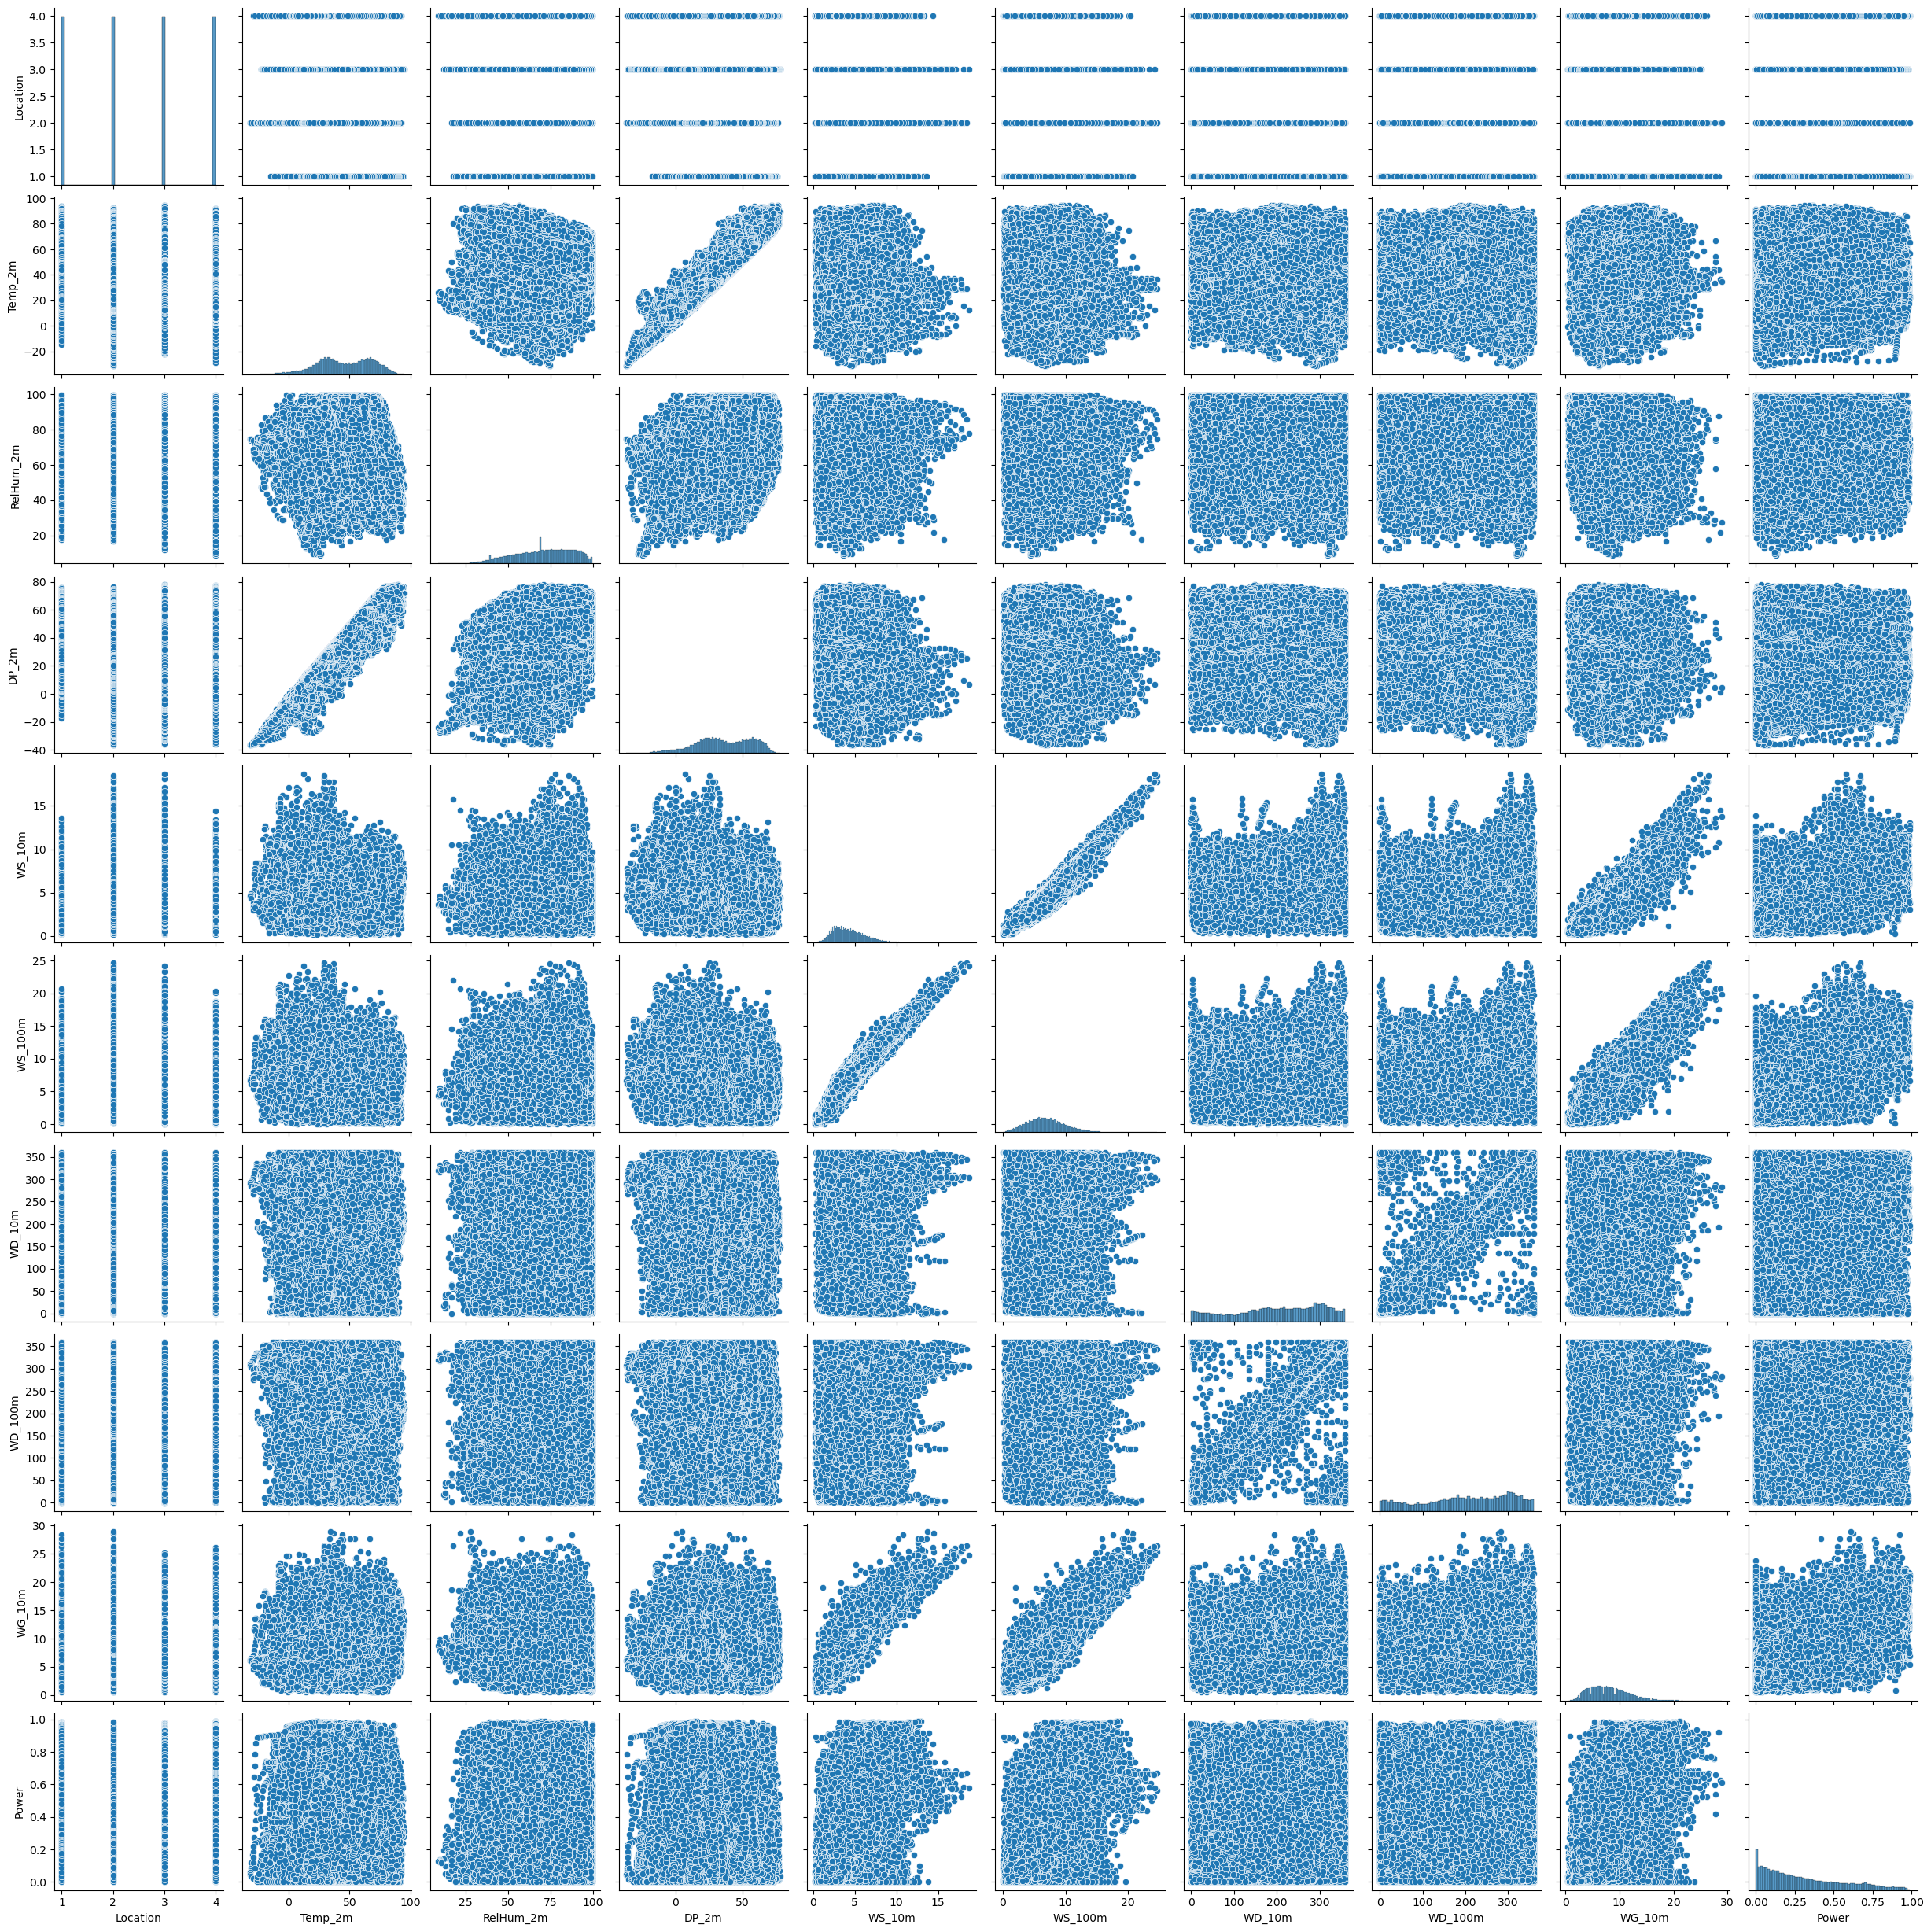

In [8]:
# Data Understanding/Visualization
sns.pairplot(wt_train_df)

In [9]:
# Based on the above pairplot, it does look like we have a few outliers here and there, especially in our windspeed graphs, so let's get started
# in dealing with our outliers. We can take the z-score from our data, which is a measurement that describes a value's relationship relative to 
# our data's mean (average). It is measured in standard deviations from the mean, so this makes it perfect for identifying if a value is an outlier.
# We'll then remove values that are more than 3 standard deviations from the mean.

# To explain what we're doing below, we take the absolute value of each z-score, and we're removing those entries which have values that have z-scores
# that are more than 3 standard deviations from the mean of our data in either direction (below or above).
# First we need to identify the columns we're going to take the z-score of. We won't be taking the z-score of the location, because it doesn't really
# apply since it's more of a categorical value than anything else.
columns_to_score = ['Temp_2m','RelHum_2m','DP_2m','WS_10m','WS_100m','WD_10m','WD_100m','WG_10m','Power']
# Then we'll take the absolute value of the zscores for the entries, because it doesn't matter if it is above or below as long as it's more than 3 std 
# dev away from the mean.
z_scores = np.abs(wt_train_df[columns_to_score].apply(zscore))
# We'll then filter the z-scores of our data to exclude any values that are greater than 3 standard deviations from the mean.
filtered_rows = (z_scores < 3).all(axis=1)
# We'll now update our data set with what we're keeping.
wt_train_df_flt = wt_train_df[filtered_rows]
wt_train_df_flt.describe()

Location        Temp_2m      RelHum_2m          DP_2m  \
count  138519.000000  138519.000000  138519.000000  138519.000000   
mean        2.501281      46.117744      70.478512      36.092496   
std         1.120388      21.803271      16.955317      20.827574   
min         1.000000     -19.820400      19.664205     -26.927405   
25%         1.000000      29.679600      57.664205      21.272595   
50%         3.000000      46.279600      72.664205      35.872595   
75%         4.000000      64.679600      84.664205      54.072595   
max         4.000000      94.479600      99.664205      78.272595   

              WS_10m        WS_100m         WD_10m        WD_100m  \
count  138519.000000  138519.000000  138519.000000  138519.000000   
mean        4.282069       6.828647     200.037186     199.993453   
std         1.903810       2.911459     100.063676     101.088483   
min         0.165389       0.007799       0.051683      -0.942685   
25%         2.805389       4.717799     127.051683     126.057315   
50%         4.015389       6.677799     210.051683     210.057315   
75%         5.515389       8.767799     287.051683     288.057315   
max        10.425389      16.067799     359.051683     359.057315   

              WG_10m          Power  
count  138519.000000  138519.000000  
mean        7.910036       0.309281  
std         3.446334       0.251757  
min         0.436515      -0.000004  
25%         5.236515       0.098696  
50%         7.536515       0.244196  
75%        10.236515       0.480096  
max        18.836515       0.985896

In [10]:
# We've now cut our dataframe down from 140160 entries to 138519 entries - meaning we've removed about 1641 entries that were outliers
# from our data. Awesome!

In [11]:
# Model 1
# We'll start by separating our target, the "Power" column, from the rest of our features.
X = wt_train_df_flt.drop(labels = 'Power', axis = 1)
y = wt_train_df_flt['Power']

In [12]:
# Next we split our data into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (110815, 9)
X_test (27704, 9)
y_train (110815,)
y_test (27704,)


In [13]:
# We're going to use a Linear Regression model this time. We're going to do this because it seems like it would be perfect for what we're doing, which is
# predicting unknown target values based on known values.
wt_linear_model = linear_model.LinearRegression()
wt_linear_model.fit(X_train, y_train)

LinearRegression()

In [14]:
# Now to predict and see how well our model performs!
y_pred = wt_linear_model.predict(X_train)
# This gets us the R-Squared score of our model, which we previously talked about.
print(wt_linear_model.score(X_train, y_train))
# And this generates the RMSE score of our model.
print(np.sqrt(mean_squared_error(y_train, y_pred)))

0.4961092927436167
0.178789351836086


In [15]:
# Currently, our model has an R-Squared value of about .49, which isn't great. Typically, the closer a value is to 1 the better, and our score right
# now isn't looking so hot. In our next experiment, we'll attempt to remedy this by removing some of the columns that aren't as correlated to our power
# generated, which we'll use a correlation matrix to gauge.
# On the flip side, our RMSE score is actually pretty solid! It's surprisingly close to 0, so our model does pretty well at predicting close to the actual
# power values!

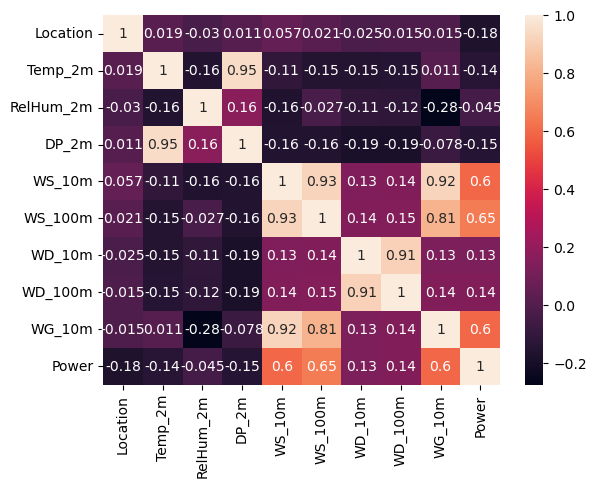

In [16]:
# Experiment 2
# For the second experiment I'd like to try removing a few of our features that aren't really correlated with our target feature.
# Now let's take a peek at the relationships between our values, to do this, we'll be using a correlation matrix.
sns.heatmap(wt_train_df_flt.corr(), annot = True)
plt.show()

In [17]:
# Our features that have the highest correlation to the power generated are the Wind Speed at 10m, Wind Speed at 100m, and Wind Gusts at 10m.
# Because of this, we'll try another Linear Regression model using only wind speeds at 10 and 100 meters, and wind gusts at 10m. This means we'll be 
# dropping the columns for Location, Temperature, Relative Humidity, Dew Point, and wind direction at 10 and 100m.

In [18]:
# We'll start by dropping the previously mentioned columns, then we'll separate our target column once more.
wt_train_df_flt2 = wt_train_df_flt.drop('Temp_2m', axis = 1)
wt_train_df_flt2 = wt_train_df_flt2.drop('Location', axis = 1)
wt_train_df_flt2 = wt_train_df_flt2.drop('RelHum_2m', axis = 1)
wt_train_df_flt2 = wt_train_df_flt2.drop('DP_2m', axis = 1)
wt_train_df_flt2 = wt_train_df_flt2.drop('WD_10m', axis = 1)
wt_train_df_flt2 = wt_train_df_flt2.drop('WD_100m', axis = 1 )
X2 = wt_train_df_flt2.drop(labels = 'Power', axis = 1)
y2 = wt_train_df_flt2['Power']

In [19]:
# We'll also split up our data into test and train sets once more.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .2, random_state = 42)
print("X_train2", X_train2.shape)
print("X_test2", X_test2.shape)
print("y_train2", y_train2.shape)
print("y_test2", y_test2.shape)

X_train2 (110815, 3)
X_test2 (27704, 3)
y_train2 (110815,)
y_test2 (27704,)


In [20]:
# Time to create our model and fit data to it!
wt_linear_model2 = linear_model.LinearRegression()
wt_linear_model2.fit(X_train2, y_train2)
# Let's evaluate it now.
y_pred2 = wt_linear_model2.predict(X_train2)
print(wt_linear_model2.score(X_train2, y_train2))
print(np.sqrt(mean_squared_error(y_train2, y_pred2)))

0.4647408276373267
0.18427038128302245


In [21]:
# Sadly, our model now produces ever-so-slightly worse predictions with our R-Squared score dropping by about .03, and our RMSE score increasing by about
# .01. I didn't expect this because I figured that our score would improve with less bloat from lesser correlated features in the mix. This suggests
# there may be another factor at play, such as the location of our turbines. Let's look at that next!

In [22]:
# Experiment 3
# I want to separate our data in order to look at the power generated by the turbines at each separate location.

In [23]:
# We'll backtrack to our filtered data set (the one where we've already dropped outliers, time, and unnamed: 0 columns) and split it into the 
# 4 different turbine locations.
wt_1 = wt_train_df_flt[wt_train_df_flt['Location']== 1]
wt_2 = wt_train_df_flt[wt_train_df_flt['Location']== 2]
wt_3 = wt_train_df_flt[wt_train_df_flt['Location']== 3]
wt_4 = wt_train_df_flt[wt_train_df_flt['Location']== 4]

In [24]:
# Wind Turbine Location 1
wt_1.describe()

Location       Temp_2m     RelHum_2m         DP_2m        WS_10m  \
count   34822.0  34822.000000  34822.000000  34822.000000  34822.000000   
mean        1.0     47.247293     71.991728     37.796224      3.750078   
std         0.0     19.467290     16.748881     18.822979      1.602365   
min         1.0    -14.620400     19.664205    -17.527405      0.165389   
25%         1.0     31.779600     59.664205     23.472595      2.585389   
50%         1.0     46.279600     73.664205     37.372595      3.475389   
75%         1.0     63.679600     85.664205     53.872595      4.765389   
max         1.0     93.879600     99.664205     75.872595      9.825389   

            WS_100m        WD_10m       WD_100m        WG_10m         Power  
count  34822.000000  34822.000000  34822.000000  34822.000000  34822.000000  
mean       6.287366    201.480664    201.216697      7.689691      0.402823  
std        2.620822     96.974314     98.511891      3.451752      0.284251  
min        0.107799      0.051683     -0.942685      0.436515     -0.000004  
25%        4.407799    127.051683    126.057315      4.936515      0.150796  
50%        6.107799    223.051683    224.057315      7.236515      0.347346  
75%        8.007799    276.051683    277.057315      9.936515      0.651196  
max       15.527799    359.051683    359.057315     18.836515      0.985696

In [25]:
# We've got bout 35,000 entries that are from Location 1, so this should be enough to build a decent model!
# We'll do the same process for all of the following models, where we split the target from the data, create train and test sets at an 80/20 ratio, 
# create the model, and print our results. We'll evaluate each individually, then take a look at the bigger picture!
X = wt_1.drop(labels = 'Power', axis = 1)
y = wt_1['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
wt_1_lm = linear_model.LinearRegression()
wt_1_lm.fit(X_train, y_train)
y_pred = wt_1_lm.predict(X_train)
print("R-Squared: ", wt_1_lm.score(X_train, y_train))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred)))

X_train (27857, 9)
X_test (6965, 9)
y_train (27857,)
y_test (6965,)
R-Squared:  0.6183843354245468
RMSE:  0.17551267418407876


In [26]:
# This model performs significantly better than our initial model, this may mean that some locations are dragging down our results, but for now we'll
# hold that thought. Our RMSE is about on par with our initial model as well, so this model is performs really well!

In [27]:
# Wind Turbine Location 2
wt_2.describe()

Location       Temp_2m     RelHum_2m         DP_2m        WS_10m  \
count   34240.0  34240.000000  34240.000000  34240.000000  34240.000000   
mean        2.0     42.146756     70.315899     32.113539      4.754643   
std         0.0     23.445184     16.701965     21.102631      2.027169   
min         2.0    -19.820400     19.664205    -26.927405      0.165389   
25%         2.0     25.079600     58.664205     18.072595      3.165389   
50%         2.0     42.179600     72.664205     32.072595      4.575389   
75%         2.0     62.279600     83.664205     50.372595      6.155389   
max         2.0     92.379600     99.664205     76.172595     10.425389   

            WS_100m        WD_10m       WD_100m        WG_10m         Power  
count  34240.000000  34240.000000  34240.000000  34240.000000  34240.000000  
mean       7.432421    206.394206    204.404044      8.299371      0.260148  
std        3.138597    103.897288    105.683065      3.401441      0.208648  
min        0.147799      0.051683     -0.942685      0.436515     -0.000004  
25%        5.107799    130.051683    125.057315      5.636515      0.086696  
50%        7.357799    224.051683    217.057315      8.036515      0.207096  
75%        9.647799    298.051683    301.057315     10.636515      0.393996  
max       16.047799    359.051683    359.057315     18.836515      0.985896

In [28]:
# We've got bout 34,000 entries that are from Location 2, so this should be sufficient to build a model!
X = wt_2.drop(labels = 'Power', axis = 1)
y = wt_2['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
wt_2_lm = linear_model.LinearRegression()
wt_2_lm.fit(X_train, y_train)
y_pred = wt_2_lm.predict(X_train)
print("R-Squared: ", wt_2_lm.score(X_train, y_train))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred)))

X_train (27392, 9)
X_test (6848, 9)
y_train (27392,)
y_test (6848,)
R-Squared:  0.44295334128844366
RMSE:  0.15583336498184827


In [29]:
# This model has an R-Squared value of .44, which is slightly worse than that of our initial model. This one could be a culprit in our initial model's
# poorer performance. However, it does have a slightly lower RMSE value - which means it's predictions were closer to the actual values.

In [30]:
# Wind Turbine Location 3
wt_3.describe()

Location       Temp_2m     RelHum_2m         DP_2m        WS_10m  \
count   34655.0  34655.000000  34655.000000  34655.000000  34655.000000   
mean        3.0     48.715722     68.532939     37.825370      4.463788   
std         0.0     22.318090     17.533032     21.926877      1.970482   
min         3.0    -19.720400     19.664205    -26.527405      0.165389   
25%         3.0     31.279600     54.664205     22.172595      2.915389   
50%         3.0     49.579600     69.664205     37.772595      4.215389   
75%         3.0     67.879600     83.664205     57.472595      5.755389   
max         3.0     94.479600     99.664205     78.272595     10.425389   

            WS_100m        WD_10m       WD_100m        WG_10m         Power  
count  34655.000000  34655.000000  34655.000000  34655.000000  34655.000000  
mean       6.996482    194.178446    194.238962      8.031183      0.321752  
std        2.932109    102.204960    102.527774      3.516491      0.251020  
min        0.007799      0.051683     -0.942685      0.436515     -0.000004  
25%        4.887799    125.051683    125.057315      5.336515      0.104596  
50%        6.907799    191.051683    193.057315      7.636515      0.268796  
75%        8.957799    289.051683    289.057315     10.336515      0.513196  
max       16.017799    359.051683    359.057315     18.836515      0.977196

In [31]:
# We've got bout 35,000 entries that are from Location 3, so this should be sufficient to build a model as well.
X = wt_3.drop(labels = 'Power', axis = 1)
y = wt_3['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
wt_3_lm = linear_model.LinearRegression()
wt_3_lm.fit(X_train, y_train)
y_pred = wt_3_lm.predict(X_train)
print("R-Squared: ", wt_3_lm.score(X_train, y_train))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred)))

X_train (27724, 9)
X_test (6931, 9)
y_train (27724,)
y_test (6931,)
R-Squared:  0.389298113035603
RMSE:  0.19589308398025804


In [32]:
# This model's R-Squared score is even lower than that of turbine 2's model. Yikes. The RMSE score of this model was also worse than the initial model's.
# Double yikes.

In [33]:
# Wind Turbine Location 4
wt_4.describe()

Location       Temp_2m     RelHum_2m         DP_2m        WS_10m  \
count   34802.0  34802.000000  34802.000000  34802.000000  34802.000000   
mean        4.0     46.307406     71.061768     36.576940      4.168473   
std         0.0     21.274989     16.631046     20.820647      1.843725   
min         4.0    -19.620400     19.664205    -26.927405      0.165389   
25%         4.0     30.079600     58.664205     21.372595      2.725389   
50%         4.0     46.279600     72.664205     36.672595      3.935389   
75%         4.0     64.679600     84.664205     54.647595      5.365389   
max         4.0     92.179600     99.664205     77.472595     10.425389   

            WS_100m        WD_10m       WD_100m        WG_10m         Power  
count  34802.000000  34802.000000  34802.000000  34802.000000  34802.000000  
mean       6.609089    198.172509    200.160326      7.626823      0.251605  
std        2.808181     96.657156     97.232681      3.371100      0.226369  
min        0.007799      0.051683      0.057315      0.536515     -0.000004  
25%        4.607799    126.051683    127.057315      5.036515      0.068696  
50%        6.507799    206.051683    210.057315      7.236515      0.188696  
75%        8.447799    283.051683    285.057315      9.836515      0.372096  
max       16.067799    359.051683    359.057315     18.836515      0.978396

In [34]:
# We've got bout 35,000 entries that are from Location 4, so this should be sufficient to build a model as well.
X = wt_4.drop(labels = 'Power', axis = 1)
y = wt_4['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
wt_4_lm = linear_model.LinearRegression()
wt_4_lm.fit(X_train, y_train)
y_pred = wt_4_lm.predict(X_train)
print("R-Squared: ", wt_4_lm.score(X_train, y_train))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred)))

X_train (27841, 9)
X_test (6961, 9)
y_train (27841,)
y_test (6961,)
R-Squared:  0.6968848783083041
RMSE:  0.12446564544282326


In [35]:
# The model for location 4 performed well! Its R-Squared value is good, and it actually has the best RMSE score out of all of our models. Awesome, now
# let's look at what all of this means.

In [36]:
# Once we separated the models by location, we saw that locations 2 and 3 produce much lower scores in comparison to locations 1 and 4. Location seems
# to play a huge role in the correlation of the features versus the power generated by wind turbines. This makes perfect sense because if a turbine is 
# placed in a terrible location, it would produce power less consistently and less efficiently than a turbine placed in an average or exceptional 
# location. It also could suggest some issues with our model, such as issues with the fit of the line, issues identifying trends/patterns, or it 
# could suggest that our initial model was overfitting to some locations, and underfitting to others. There could also be missing features that we
# just don't know about too, such as ages of these wind turbines, anything about where the location actually are located, like on top of a hill or 
# in a valley, or something else completely.

In [37]:
# Impact:
# This project has a lot of potential for impact within the realm of alternative/renewable energy sources. More in depth models than my own could play
# extremely important roles in deciding the locations of future Wind Turbines. Typically in the United States, wind turbines are placed in wide open 
# areas, like at the coast or in the plains of the western regions of our country. Models such as these could help cherry pick the best of these 
# locations, and increase efficiency greatly! These sort of models could help prevent waste of resources in building new turbines as well. If a model
# can provide relatively accurate information as to what we can expect from a turbine in a new location, it would help those in charge determine whether
# or not a new turbine would actually be worth it to build a wind turbine there. A potential issue with models like mine could be if we assume that these
# turbines are operating at a constant. As anyone who has been outside knows, the wind is not a constant thing. Some days there may be no wind at all, 
# and other days the wind may be strong enough to knock someone over. This would have to be taken into consideration as well with any actual model.
# Another thing that would need to be considered is the environmental impact of more turbines. Any piece of machinery is guaranteed to fail at some
# point or other. It is not a question of if, but when. There are countless instances of fires, or other forms of mechanical failure that have already
# occurred with wind turbines, with one as recently as January, 2024 in Colorado. These sorts of failures can lead to disasters such as wildfires,
# especially in more arid places, and loss of life drastically affecting ecosystems. These are all things that should be considered, and with proper 
# maintenance and care can be mitigated at the very least.

In [38]:
# Conclusion:
# To answer our initial question, yes, we can indeed create a model for wind turbines that accurately predicts power generated based off of other
# features. To get a decently accurate model, we had to split it up by the specific locations and bring the information down to a finer scale, instead of
# a more general prediction, but I feel satisfied with what we came up with. The biggest factor in improving the model I'd have to say was splitting up
# the model by location, which increased our R-Squared scores by upwards of 20% (.20), as well as helped identify what was dragging down the initial
# model. I also saw that just removing features from a model just because they aren't as correlated to the target value doesn't necessarily mean that 
# the model will perform better. We saw this when in the second experiment the R-Squared score actually went down instead of up when we removed values
# that had lower values in our correlation matrix.

# I've learned a lot from working on this project about Linear Regression, R-Squared values, and most definitely the importance of features and the
# roles that they play in our models. Just because something has a lesser correlation, doesn't mean that it isn't still valuable information to have, and
# when broken down into more parts, may even paint a more clear picture of what is actually going on. I've also learned that I really enjoy tinkering
# and tweaking these models, adjusting what features are included and aren't, and thinking through the logic of why something should or shouldn't be 
# included in a model. Doing projects like this, and exploring logic and choices such as those detailed throughout the project can prove to be very
# valuable, and help me become better overall when working with data, be it in the logic of building a model, or in the actual coding portion. 
# Specific to this project, I really enjoyed the subject matter of the data. However, I did feel like the dataset was lacking in the information on
# the write up when I reflect on it. Some of the features were unclear, especially location. The initial data set on kaggle didn't seem to include any
# information on the specific location of these wind turbines, they could've been spread out across the US, the world, or across a single field, and we
# wouldn't know. Features like these could potentially play a huge role in the meaning and outcomes of the projects. I think my biggest take away in 
# this aspect is that I seriously need to take more time and go through these data sets with a fine tooth comb when I'm selecting them. 

# Overall, I'm mostly satisfied with the work I've done in this project, but I wish I could've spent more time tinkering with the models, and had more
# features to work with. In the future, I'll try to mitigate this as best as possible on my end (where my other classes and available datasets allow
# haha).

In [40]:
# References
# Kaggle Data Set: https://www.kaggle.com/datasets/sudhanvahg/wind-turbine-power-generation-forecasting
